# 0. Install Dependencies

In [1]:
#!pip install tensorflow==2.3.1 gym keras-rl2 gym[atari]

In [2]:
#pip install ale-py

# 1. Test Random Environment with OpenAI Gym

In [3]:
import gym 
import random
import matplotlib.pyplot as plt
from IPython import display

In [4]:
env = gym.make("ALE/SpaceInvaders-v5")#, render_mode="rgb_array"
#env.metadata["render_fps"] = 120
height, width, channels = env.observation_space.shape
actions = env.action_space.n

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [5]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [6]:
%matplotlib inline

import os
import re
import gym
import time
import copy
import random
import warnings
import numpy as np

import torch
import torchvision
import torch.nn as nn

from IPython import display
from skimage import io
#from skimage.color import rgb2grey
from skimage.color import rgb2gray
from skimage.transform import rescale
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from collections import deque, namedtuple
plt.style.use('seaborn')
warnings.filterwarnings('ignore')

In [7]:
class DeepQNetwork(nn.Module):
    def __init__(self, num_frames, num_actions):
        super(DeepQNetwork, self).__init__()
        self.num_frames = num_frames
        self.num_actions = num_actions
        
        # Layers
        self.conv1 = nn.Conv2d(
            in_channels=num_frames,
            out_channels=16,
            kernel_size=8,
            stride=4,
            padding=2
            )
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1
            )
        self.fc1 = nn.Linear(
            in_features=3200,
            out_features=256,
            )
        self.fc2 = nn.Linear(
            in_features=256,
            out_features=num_actions,
            )
        
        # Activation Functions
        self.relu = nn.ReLU()
    
    def flatten(self, x):
        batch_size = x.size()[0]
        x = x.view(batch_size, -1)
        return x
    
    def forward(self, x):
        
        # Forward pass
        x = self.relu(self.conv1(x))  # In: (80, 80, 4)  Out: (20, 20, 16)
        x = self.relu(self.conv2(x))  # In: (20, 20, 16) Out: (10, 10, 32)
        x = self.flatten(x)           # In: (10, 10, 32) Out: (3200,)
        x = self.relu(self.fc1(x))    # In: (3200,)      Out: (256,)
        x = self.fc2(x)               # In: (256,)       Out: (4,)
        
        return x

In [13]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [9]:
class Agent:
    def __init__(self, model, memory_depth, lr, gamma, epsilon_i, epsilon_f, anneal_time, ckptdir):
        
        self.cuda = True if torch.cuda.is_available() else False
        
        self.model = model
        self.device = torch.device("cuda" if self.cuda else "cpu")
        
        if self.cuda:
            self.model = self.model.cuda()
        
        self.memory_depth = memory_depth
        self.gamma = torch.tensor([gamma], device=self.device)
        self.e_i = epsilon_i
        self.e_f = epsilon_f
        self.anneal_time = anneal_time
        self.ckptdir = ckptdir
        
        if not os.path.isdir(ckptdir):
            os.makedirs(ckptdir)
        
        self.memory = deque([], maxlen=memory_depth)
        self.clone()
        
        self.loss = nn.SmoothL1Loss()
        self.opt = torch.optim.RMSprop(self.model.parameters(), lr=lr, alpha=0.95, eps=0.01)
        
    def clone(self):
        try:
            del self.clone_model
        except:
            pass
        
        self.clone_model = copy.deepcopy(self.model)
        
        for p in self.clone_model.parameters():
            p.requires_grad = False
        
        if self.cuda:
            self.clone_model = self.clone_model.cuda()
    
    def remember(self, *args):
        self.memory.append(Transition(*args))
    
    def retrieve(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        state, action, reward, terminal, next_state = map(torch.cat, [*batch])
        return state, action, reward, terminal, next_state
    
    @property
    def memories(self):
        return len(self.memory)
    
    def act(self, state):
        q_values = self.model(state).detach()
        action = torch.argmax(q_values)
        return action.item()
    
    def process(self, state):
        #state=np.asarray(state)
        #print("gg")
        #print(state[0].shape)
        #print(state[0][35:195, :, :])
        #print(typeof(state[35:195, :, :]))
        state = rgb2gray(state[35:195, :, :])#state[0][35:195, :])#
        state = rescale(state, scale=0.5)
        state = state[np.newaxis, np.newaxis, :, :]
        return torch.tensor(state, device=self.device, dtype=torch.float)
    
    def exploration_rate(self, t):
        if 0 <= t < self.anneal_time:
            return self.e_i - t*(self.e_i - self.e_f)/self.anneal_time
        elif t >= self.anneal_time:
            return self.e_f
        elif t < 0:
            return self.e_i
    
    def save(self, t):
        save_path = os.path.join(self.ckptdir, 'model-{}'.format(t))
        torch.save(self.model.state_dict(), save_path)
    
    def load(self):
        ckpts = [file for file in os.listdir(self.ckptdir) if 'model' in file]
        steps = [int(re.search('\d+', file).group(0)) for file in ckpts]
        
        latest_ckpt = ckpts[np.argmax(steps)]
        self.t = np.max(steps)
        
        print("Loading checkpoint: {}".format(latest_ckpt))
        
        self.model.load_state_dict(torch.load(os.path.join(self.ckptdir, latest_ckpt)))
        
    def update(self, batch_size):
        self.model.zero_grad()

        state, action, reward, terminal, next_state = self.retrieve(batch_size)
        q = self.model(state).gather(1, action.view(batch_size, 1))
        qmax = self.clone_model(next_state).max(dim=1)[0]
        
        nonterminal_target = reward + self.gamma*qmax
        terminal_target = reward
        
        target = terminal.float()*terminal_target + (~terminal).float()*nonterminal_target
    
        loss = self.loss(q.view(-1), target)
        loss.backward()
        self.opt.step()

    def play(self, episodes, train=False, load=False, plot=False, render=False, verbose=False):
        has_burned_in_yet = False
        modthing=0
        self.t = 0
        metadata = dict(episode=[], reward=[])
        
        if load:
            self.load()

        try:
            progress_bar = tqdm(range(episodes), unit='episode')
            
            i = 0
            for episode in progress_bar:

                state, info = env.reset()
                state = self.process(state)
                #print(state.shape)
                done = False
                total_reward = 0

                if(render):
                    img = plt.imshow(env.render())
                while not done:
                    modthing += 1
                    if render:
                        img.set_data(env.render())
                        display.display(plt.gcf())
                        display.clear_output(wait=True)
                        time.sleep(.2)

                        
                    #print(state.size()[1])
                    while state.size()[1] < num_frames:
                        action = 1 # Fire
                        #observation, reward, terminated, truncated, info
                        new_frame, reward, done,truncated, info = env.step(action)
                        new_frame = self.process(new_frame)

                        state = torch.cat([state, new_frame], 1)
                    #print("hmm")
                    #print(state.shape)
                    
                    if train and np.random.uniform() < self.exploration_rate(self.t-burn_in):
                        action = np.random.choice(num_actions)

                    else:
                        action = self.act(state)

                    new_frame, reward, done,truncated, info = env.step(action)
                    new_frame = self.process(new_frame)

                    new_state = torch.cat([state, new_frame], 1)
                    new_state = new_state[:, 1:, :, :]
                    
                    if train:
                        reward = torch.tensor([reward], device=self.device, dtype=torch.float)
                        action = torch.tensor([action], device=self.device, dtype=torch.long)
                        done = torch.tensor([done], device=self.device, dtype=torch.uint8)
                        
                        self.remember(state, action, reward, done, new_state)

                    state = new_state
                    total_reward += reward
                    self.t += 1
                    i += 1
                    
                    if not train:
                        time.sleep(0.1)
                    
                    if train and self.t > burn_in and i > batch_size:

                        if self.t % update_interval == 0:
                            if not has_burned_in_yet:
                                print("burn in phase passed, now updating weights")
                                has_burned_in_yet = True
                            self.update(batch_size)

                        if self.t % clone_interval == 0:
                            self.clone()

                        if self.t % save_interval == 0:
                            self.save(self.t)

                    if self.t % 1000 == 0:
                        progress_bar.set_description("t = {}".format(self.t))
                if episode != None:
                    metadata['episode'].append(episode)
                if reward != None:
                    metadata['reward'].append(total_reward.cpu())

                if episode % 50 == 0 and episode != 0:
                    avg_return = np.mean(metadata['reward'][-50:])
                    print("Average return (last 50 episodes): {:.2f}".format(avg_return))
                    print("randomly choosing action",self.exploration_rate(self.t-burn_in)*100,"percent of the time")

                if plot:
                    plt.scatter(metadata['episode'], metadata['reward'])
                    plt.xlim(0, episodes)
                    plt.xlabel("Episode")
                    plt.ylabel("Return")
                    display.clear_output(wait=True)
                    display.display(plt.gcf())
            
            env.close()
            return metadata

        except KeyboardInterrupt:
            if train:
                print("Saving model before quitting...")
                self.save(self.t)
            
            env.close()
            return metadata

In [10]:
# Hyperparameters
#env = gym.make("ALE/SpaceInvaders-v5")
env = gym.make('BreakoutDeterministic-v4')
batch_size = 128
update_interval = 4
clone_interval = int(1e4)
save_interval = int(1e5)
frame_skip = None
num_frames = 4
num_actions = len(env.unwrapped.get_action_meanings())
episodes = int(1e5)#5000#
memory_depth = 50000
epsilon_i = 0.9
epsilon_f = 0.05
anneal_time = int(1e6)#episodes*400
burn_in = 1#int(5e4)
gamma = 0.99
learning_rate = 2.5e-4

In [11]:
model = DeepQNetwork(num_frames, num_actions)
agent = Agent(model, memory_depth, learning_rate, gamma, epsilon_i, epsilon_f, anneal_time, 'ckpt')

metadata = agent.play(episodes, train=True, load=False,plot=False)

  0%|          | 0/100000 [00:00<?, ?episode/s]

burn in phase passed, now updating weights
Average return (last 50 episodes): 1.00
randomly choosing action 99.21214 percent of the time
Average return (last 50 episodes): 1.08
randomly choosing action 98.42959 percent of the time
Saving model before quitting...


In [132]:
metadata


{'episode': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120],
 'reward': [tensor([140.]),
  tensor([155.]),
  tensor([105.]),
  tensor([300.]),
  tensor([75.]),
  tensor([125.]),
  tensor([75.]),
  tensor([360.]),
  tensor([105.]),
  tensor([185.]),
  tensor([105.]),
  tensor([160.]),
  tensor([180.]),
  tensor(

AttributeError: 'float' object has no attribute 'cpu'

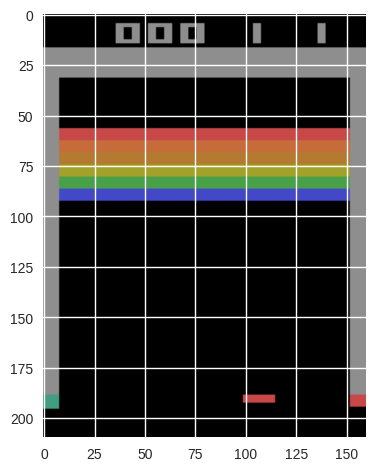

In [12]:
env = gym.make("BreakoutDeterministic-v4", render_mode="rgb_array")
#env.metadata["render_fps"] = 2
RENDER_WHILE_TRAINING = True

metadata = agent.play(1, train=False, load=True,render=True)


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
torch.Size([1, 1, 80, 80])


RuntimeError: Given groups=1, weight of size [16, 4, 8, 8], expected input[1, 1, 80, 80] to have 4 channels, but got 1 channels instead

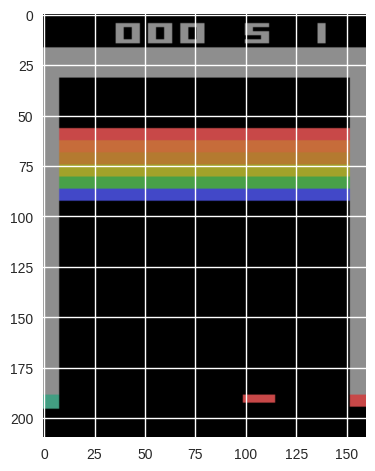

In [22]:

episodes = 5
for episode in range(1, episodes+1):
    state, info = env.reset()
    done = False
    score = 0 
    
    img = plt.imshow(env.render())
    while not done:
        print("hellpo")
        #env.render("rgb_array")
        if RENDER_WHILE_TRAINING:
            img.set_data(env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)
        print(state)
        state = agent.process(state)
        print(state.shape)
        action = agent.act(state)#random.choice([0,1,2,3,4,5])
        print(action)
        state, reward, terminated, truncated, info = env.step(action)
        score+=reward
        if terminated or truncated:
            state, info = env.reset()
    print('Episode:{} Score:{}'.format(episode, score))
env.close()